In [ ]:
#Importing Libraries
import warnings
warnings.filterwarnings("ignore")
import cv2
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import random
import shutil
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing import image
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.losses import BinaryCrossentropy
from keras.optimizers import Adam
from keras.applications import ResNet50
from keras.applications import VGG16

In [ ]:
# Checking if GPU is available
if tf.config.list_physical_devices('GPU'):
    device = "GPU"
else:
    device = "CPU"
print(f"Using {device} device")

Using GPU device


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Path folders
input_path = '/content/drive/MyDrive/cell_images'
parasite_path = os.path.join(input_path, 'Parasitized')
uninfected_path = os.path.join(input_path, 'Uninfected')

# **Exploratory Data Analysis**

In [ ]:
# Creating a dataframe to perform EDA
def create_dataframe_from_dir(directory, label):
    filenames = os.listdir(directory)
    df = pd.DataFrame({'filename': filenames, 'label': [label] * len(filenames)})
    return df

parasite_df = create_dataframe_from_dir(parasite_path, 'Parasitized')
uninfected_df = create_dataframe_from_dir(uninfected_path, 'Uninfected')

data_df = pd.concat([parasite_df, uninfected_df], ignore_index=True)

data_df = data_df.sample(frac=1).reset_index(drop=True)

print("DataFrame:")
print(data_df.head())

DataFrame:
                                          filename        label
0  C176P137NThinF_IMG_20151201_121303_cell_111.png  Parasitized
1   C184P145ThinF_IMG_20151203_102543_cell_158.png  Parasitized
2     C73P34_ThinF_IMG_20150815_111422_cell_63.png   Uninfected
3   C68P29N_ThinF_IMG_20150819_133350_cell_157.png  Parasitized
4     C88P49ThinF_IMG_20150820_151626_cell_188.png  Parasitized


### Summary of the DataFrame

In [ ]:
print("Summary of the DataFrame:")
print(data_df.info())
print("\nShape of DataFrame:", data_df.shape)
print("\nNumber of Images:", data_df.shape[0])
print("Number of Different Categories:", data_df['label'].nunique())

Summary of the DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27590 entries, 0 to 27589
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  27590 non-null  object
 1   label     27590 non-null  object
dtypes: object(2)
memory usage: 431.2+ KB
None

Shape of DataFrame: (27590, 2)

Number of Images: 27590
Number of Different Categories: 2


### Number of Images in Each Class

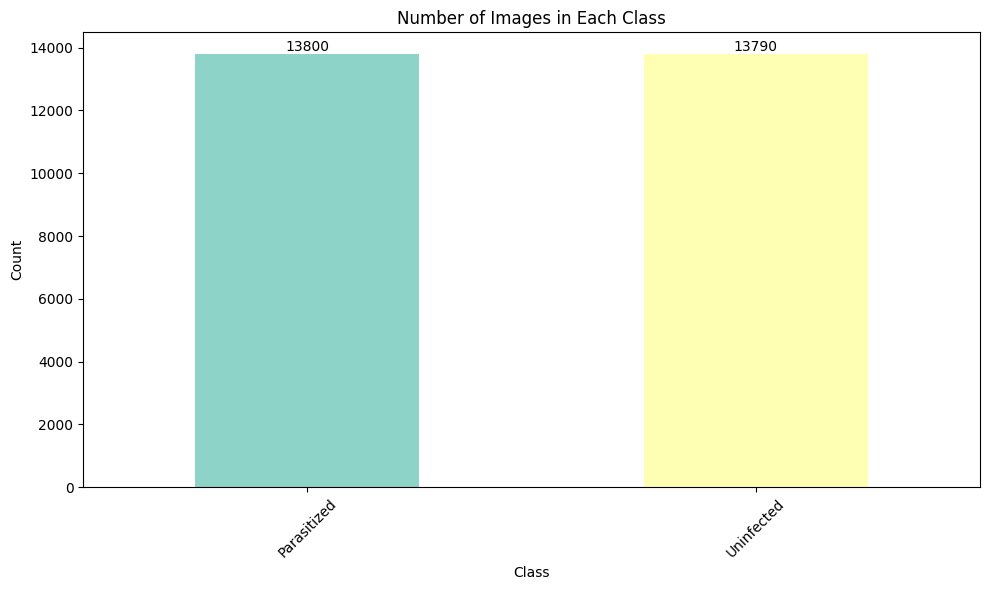

In [ ]:
class_counts = data_df['label'].value_counts()
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar', color=plt.cm.Set3.colors)
plt.title('Number of Images in Each Class')
plt.xlabel('Class')
plt.ylabel('Count')

for i, count in enumerate(class_counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

*The number of images for both the classes are same indicating it is a Balanced Dataset*

### Displaying first 5 images of Parasitized and Uninfected classes

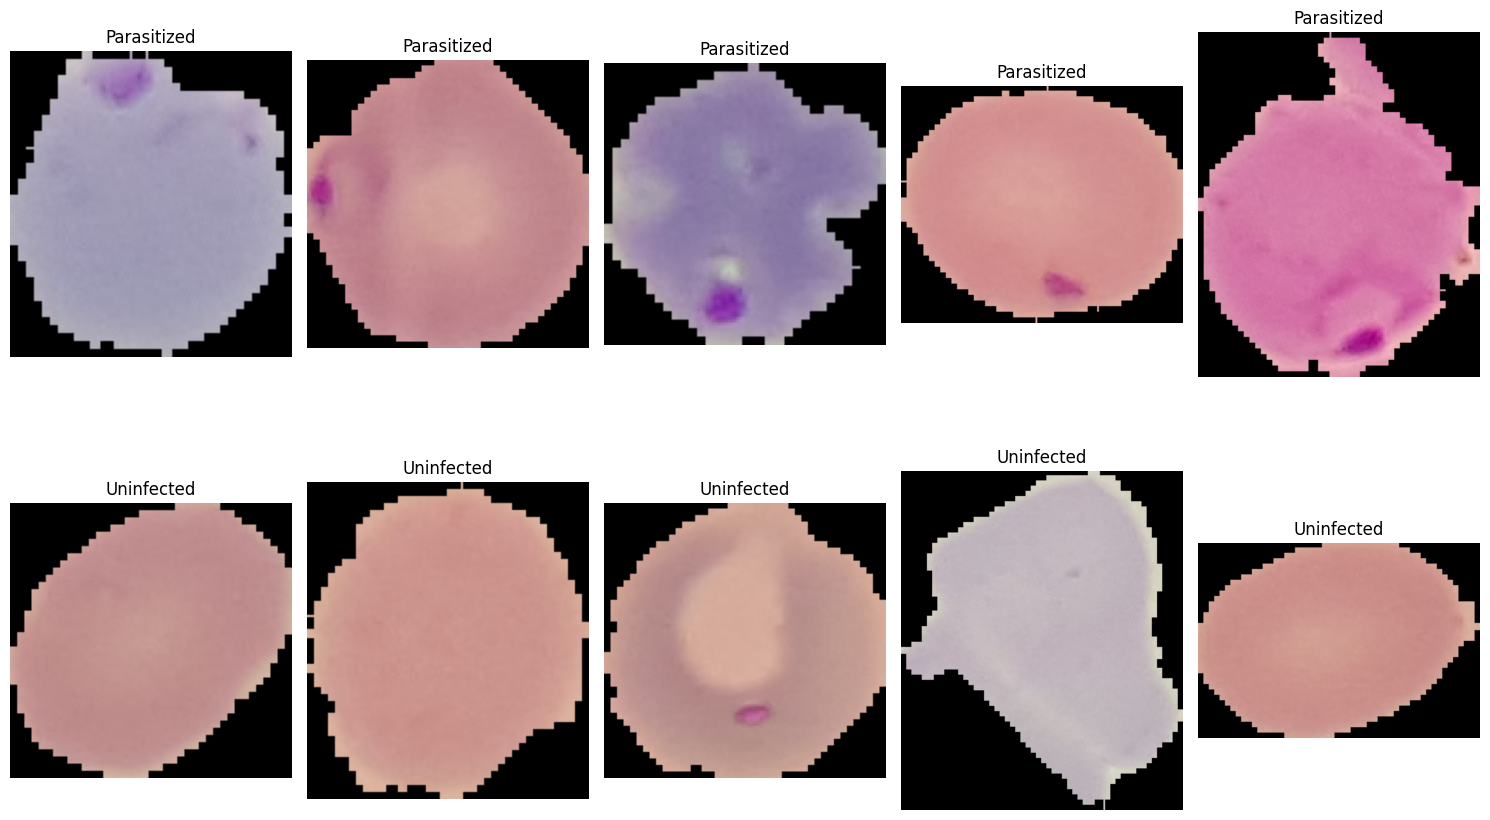

In [ ]:
def display_first_images(data_df):
    classes = data_df['label'].unique()
    num_classes = len(classes)
    fig, axes = plt.subplots(num_classes, 5, figsize=(15, 10))

    for i, cls in enumerate(classes):
        class_images = data_df[data_df['label'] == cls].head()
        for j, (_, row) in enumerate(class_images.iterrows()):
            img_path = os.path.join(input_path, row['label'], row['filename'])
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[i, j].imshow(img)
            axes[i, j].set_title(row['label'])
            axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()

display_first_images(data_df)

## Preparing Data for Splitting into Train and Test

In [ ]:
train_dir = '/kaggle/working/train'
test_dir = '/kaggle/working/test'

In [ ]:
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

os.makedirs(os.path.join(train_dir, 'Parasitized'), exist_ok=True)
os.makedirs(os.path.join(train_dir, 'Uninfected'), exist_ok=True)
os.makedirs(os.path.join(test_dir, 'Parasitized'), exist_ok=True)
os.makedirs(os.path.join(test_dir, 'Uninfected'), exist_ok=True)


In [ ]:
def split_data(source, train, test, split_size):
    files = os.listdir(source)
    random.shuffle(files)
    split_index = int(len(files) * split_size)
    train_files = files[:split_index]
    test_files = files[split_index:]

    for file in train_files:
        shutil.copy(os.path.join(source, file), os.path.join(train, file))

    for file in test_files:
        shutil.copy(os.path.join(source, file), os.path.join(test, file))
split_size=0.8
split_data(parasite_path, os.path.join(train_dir, 'Parasitized'), os.path.join(test_dir, 'Parasitized'), split_size)

split_data(uninfected_path, os.path.join(train_dir, 'Uninfected'), os.path.join(test_dir, 'Uninfected'), split_size)

## Defining ImageDataGenerator with Data Augmentation for Both Train and Test Data

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='binary'
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='binary'
)

Found 144 images belonging to 2 classes.
Found 0 images belonging to 2 classes.


# Model Building

#### For all the 3 models , optimizer = 'adam'  and loss='binary_crossentropy' as they are best suited for binary classifications

### Model 1 : Simple CNN

In [ ]:
X_train, y_train = next(train_generator)

In [ ]:
from keras import regularizers

cnn_model = Sequential()

cnn_model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(224, 224, 3), kernel_regularizer=regularizers.l2(0.01)))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.3))

cnn_model.add(Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.5))

cnn_model.add(Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.5))

cnn_model.add(Flatten())

cnn_model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(0.5))

cnn_model.add(Dense(1, activation='sigmoid'))

In [ ]:
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Training the Model

In [ ]:
history = cnn_model.fit(train_generator, validation_data=test_generator, epochs=5, verbose=1)
train_accuracy1 = history.history['accuracy']
train_loss1 = history.history['loss']
test_accuracy1 = history.history['val_accuracy']
test_loss1 = history.history['val_loss']

for epoch, (train_acc, train_loss, test_acc, test_loss) in enumerate(zip(train_accuracy1, train_loss1, test_accuracy1, test_loss1), 1):
    print(f"Epoch {epoch}: Training Accuracy: {train_acc:.2f}%, Training Loss: {train_loss:.4f}, Testing Accuracy: {test_acc:.2f}%, Testing Loss: {test_loss:.4f}")

### Analysis Of Results for Model 1

### Comparison of Train and Test Accuracy

In [ ]:
plt.plot(train_accuracy1, label="CNN Train Accuracy")
plt.plot(test_accuracy1, label="CNN Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Comparison of Train Accuracy and Test Accuracy w.r.t Epoch for CNN")
plt.legend()
plt.show()

NameError: name 'train_accuracy1' is not defined

### Comparison of Train and Test Loss

In [ ]:
plt.plot(train_loss1, label="Train Loss")
plt.plot(test_loss1, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Comparison of Train Loss and Test Loss w.r.t Epoch for CNN")
plt.legend()
plt.show()

NameError: name 'train_loss1' is not defined

### Confusion Matrix

In [ ]:
y_pred = cnn_model.predict(test_generator)
y_pred_classes = np.round(y_pred)

true_classes = test_generator.classes

cm1 = confusion_matrix(true_classes, y_pred_classes)

print("Confusion Matrix:")
print(cm1)

ValueError: Asked to retrieve element 0, but the Sequence has length 0

### Heat map of confusion matrix

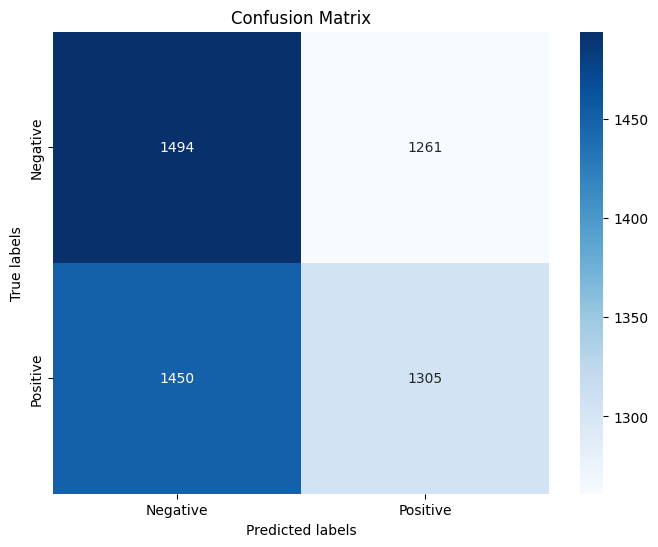

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

### Model 2: ResNet50

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
res_model = Sequential()
res_model.add(base_model)
res_model.add(Flatten())
res_model.add(Dense(256, activation='relu'))
res_model.add(BatchNormalization())
res_model.add(Dropout(0.5))
res_model.add(Dense(1, activation='sigmoid'))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


### Training the Model

In [ ]:
res_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = res_model.fit(train_generator, validation_data=test_generator, epochs=5, verbose=1)

train_accuracy2 = history.history['accuracy']
train_loss2 = history.history['loss']
test_accuracy2 = history.history['val_accuracy']
test_loss2 = history.history['val_loss']

for epoch, (train_acc, train_loss, test_acc, test_loss) in enumerate(zip(train_accuracy2, train_loss2, test_accuracy2, test_loss2), 1):
    print(f"Epoch {epoch}: Training Accuracy: {train_acc:.2f}%, Training Loss: {train_loss:.4f}, Testing Accuracy: {test_acc:.2f}%, Testing Loss: {test_loss:.4f}")

Epoch 1/5


2024-03-01 03:32:51.212688: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[64,1024,14,14]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,2048,7,7]{3,2,1,0}, f32[2048,1024,1,1]{3,2,1,0}), window={size=1x1 stride=2x2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-03-01 03:32:51.213856: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.001287094s
Trying algorithm eng0{} for conv (f32[64,1024,14,14]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,2048,7,7]{3,2,1,0}, f32[2048,1024,1,1]{3,2,1,0}), window={size=1x1 stride=2x2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...


345/345 ━━━━━━━━━━━━━━━━━━━━ 364s 801ms/step - accuracy: 0.9286 - loss: 0.2689 - val_accuracy: 0.5000 - val_loss: 0.7169
Epoch 2/5


W0000 00:00:1709264282.567206     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


345/345 ━━━━━━━━━━━━━━━━━━━━ 237s 675ms/step - accuracy: 0.9538 - loss: 0.1431 - val_accuracy: 0.5287 - val_loss: 0.6838
Epoch 3/5
345/345 ━━━━━━━━━━━━━━━━━━━━ 239s 678ms/step - accuracy: 0.9595 - loss: 0.1261 - val_accuracy: 0.9392 - val_loss: 0.2119
Epoch 4/5
345/345 ━━━━━━━━━━━━━━━━━━━━ 236s 671ms/step - accuracy: 0.9597 - loss: 0.1224 - val_accuracy: 0.9583 - val_loss: 0.1352
Epoch 5/5
345/345 ━━━━━━━━━━━━━━━━━━━━ 236s 671ms/step - accuracy: 0.9566 - loss: 0.1277 - val_accuracy: 0.9359 - val_loss: 0.2096
Epoch 1: Training Accuracy: 0.95%, Training Loss: 0.1865, Testing Accuracy: 0.50%, Testing Loss: 0.7169
Epoch 2: Training Accuracy: 0.95%, Training Loss: 0.1417, Testing Accuracy: 0.53%, Testing Loss: 0.6838
Epoch 3: Training Accuracy: 0.96%, Training Loss: 0.1279, Testing Accuracy: 0.94%, Testing Loss: 0.2119
Epoch 4: Training Accuracy: 0.96%, Training Loss: 0.1234, Testing Accuracy: 0.96%, Testing Loss: 0.1352
Epoch 5: Training Accuracy: 0.96%, Training Loss: 0.1233, Testing Accu

### Analysis Of Results for Model 2

### Comparison of Train and Test Accuracy

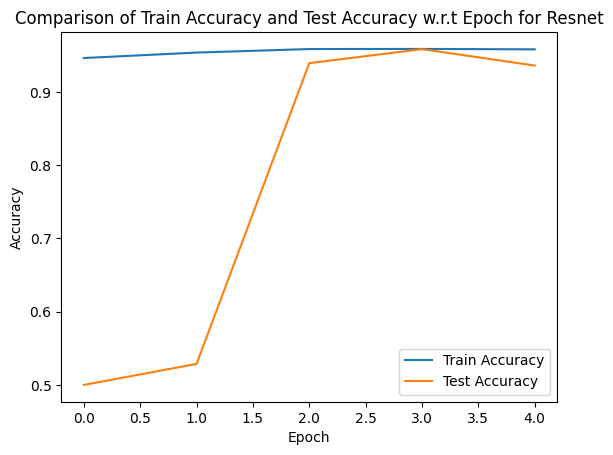

In [ ]:
plt.plot(train_accuracy2, label="Train Accuracy")
plt.plot(test_accuracy2, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Comparison of Train Accuracy and Test Accuracy w.r.t Epoch for Resnet")
plt.legend()
plt.show()

### Comparison of Train and Test Loss

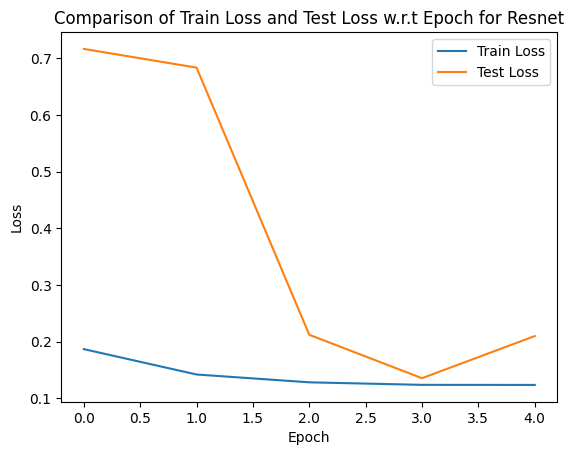

In [ ]:
plt.plot(train_loss2, label="Train Loss")
plt.plot(test_loss2, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Comparison of Train Loss and Test Loss w.r.t Epoch for Resnet")
plt.legend()
plt.show()

### Confusion Matrix

In [ ]:
y_pred = res_model.predict(test_generator)
y_pred_classes = np.round(y_pred)

true_classes = test_generator.classes

cm2 = confusion_matrix(true_classes, y_pred_classes)

print("Confusion Matrix:")
print(cm2)

87/87 ━━━━━━━━━━━━━━━━━━━━ 19s 173ms/step
Confusion Matrix:
[[1290 1465]
 [1284 1471]]


### Heat Map of Confusion Matrix

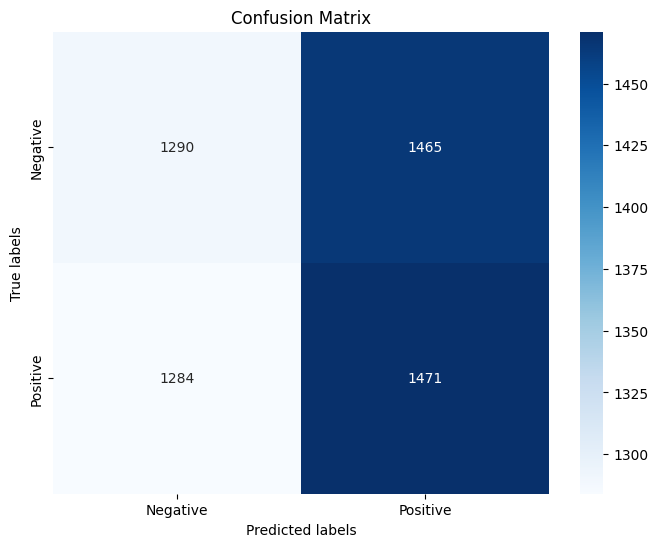

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

### Model 3 : VGG16

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg_model = Sequential()
vgg_model.add(base_model)
vgg_model.add(Flatten())
vgg_model.add(Dense(256, activation='relu'))
vgg_model.add(BatchNormalization())
vgg_model.add(Dropout(0.5))
vgg_model.add(Dense(1, activation='sigmoid'))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


### Training the Model

In [ ]:
vgg_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = vgg_model.fit(train_generator, validation_data=test_generator, epochs=5, verbose=1)

train_accuracy3 = history.history['accuracy']
train_loss3 = history.history['loss']
test_accuracy3 = history.history['val_accuracy']
test_loss3 = history.history['val_loss']

for epoch, (train_acc, train_loss, test_acc, test_loss) in enumerate(zip(train_accuracy3, train_loss3, test_accuracy3, test_loss3), 1):
    print(f"Epoch {epoch}: Training Accuracy: {train_acc:.2f}%, Training Loss: {train_loss:.4f}, Testing Accuracy: {test_acc:.2f}%, Testing Loss: {test_loss:.4f}")

Epoch 1/5


2024-03-01 03:56:27.865413: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng15{k5=1,k6=0,k7=1,k10=1} for conv (f32[64,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,3,224,224]{3,2,1,0}, f32[64,3,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-03-01 03:56:28.345864: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100352: 3.87759, expected 3.06898
2024-03-01 03:56:28.345928: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100353: 6.47516, expected 5.66656
2024-03-01 03:56:28.345938: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100354: 6.23991, expected 5.43131
2024-03-01 03:56:28.345946: E external/local_xla/xla/service/gpu/buffer_compar

315/345 ━━━━━━━━━━━━━━━━━━━━ 19s 653ms/step - accuracy: 0.7256 - loss: 0.5672

2024-03-01 04:01:02.360257: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.63498, expected 3.85968
2024-03-01 04:01:02.360319: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 6.55784, expected 5.78254
2024-03-01 04:01:02.360328: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 6.61282, expected 5.83752
2024-03-01 04:01:02.360336: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 6.34499, expected 5.56968
2024-03-01 04:01:02.360344: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 6.25159, expected 5.47629
2024-03-01 04:01:02.360351: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 5.43964, expected 4.66434
2024-03-01 04:01:02.360359: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 9: 6.54333, expected 5.76803
2024-03-01 04:01:02.360366: E external/local_xla/xla/se

345/345 ━━━━━━━━━━━━━━━━━━━━ 0s 753ms/step - accuracy: 0.7356 - loss: 0.5497

2024-03-01 04:02:06.642163: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.64217, expected 2.7931
2024-03-01 04:02:06.642223: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 4.85027, expected 4.0012
2024-03-01 04:02:06.642233: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 4.44079, expected 3.59172
2024-03-01 04:02:06.642241: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 4.81156, expected 3.96248
2024-03-01 04:02:06.642248: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 5.0588, expected 4.20973
2024-03-01 04:02:06.642256: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 4.43719, expected 3.58812
2024-03-01 04:02:06.642264: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 4.55385, expected 3.70478
2024-03-01 04:02:06.642271: E external/local_xla/xla/servi

345/345 ━━━━━━━━━━━━━━━━━━━━ 355s 802ms/step - accuracy: 0.7359 - loss: 0.5492 - val_accuracy: 0.9563 - val_loss: 111686.3594
Epoch 2/5
345/345 ━━━━━━━━━━━━━━━━━━━━ 238s 676ms/step - accuracy: 0.9461 - loss: 0.1719 - val_accuracy: 0.9583 - val_loss: 2162421.7500
Epoch 3/5
345/345 ━━━━━━━━━━━━━━━━━━━━ 238s 676ms/step - accuracy: 0.9529 - loss: 0.1557 - val_accuracy: 0.9604 - val_loss: 842773.8125
Epoch 4/5
345/345 ━━━━━━━━━━━━━━━━━━━━ 239s 680ms/step - accuracy: 0.9532 - loss: 0.1456 - val_accuracy: 0.9592 - val_loss: 18474808.0000
Epoch 5/5
345/345 ━━━━━━━━━━━━━━━━━━━━ 239s 678ms/step - accuracy: 0.9520 - loss: 0.1532 - val_accuracy: 0.9603 - val_loss: 12170862.0000
Epoch 1: Training Accuracy: 0.84%, Training Loss: 0.3579, Testing Accuracy: 0.96%, Testing Loss: 111686.3594
Epoch 2: Training Accuracy: 0.95%, Training Loss: 0.1692, Testing Accuracy: 0.96%, Testing Loss: 2162421.7500
Epoch 3: Training Accuracy: 0.95%, Training Loss: 0.1576, Testing Accuracy: 0.96%, Testing Loss: 842773.81

### Analysis Of Results for Model 3

### Comparison of Train and Test Accuracy

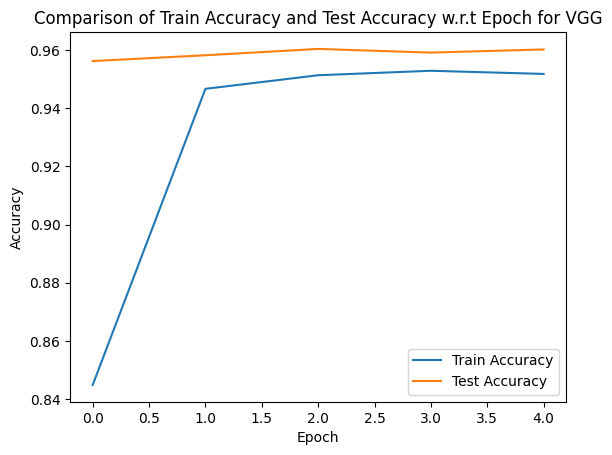

In [ ]:
plt.plot(train_accuracy3, label="Train Accuracy")
plt.plot(test_accuracy3, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Comparison of Train Accuracy and Test Accuracy w.r.t Epoch for VGG")
plt.legend()
plt.show()

### Comparison of Train and Test Loss

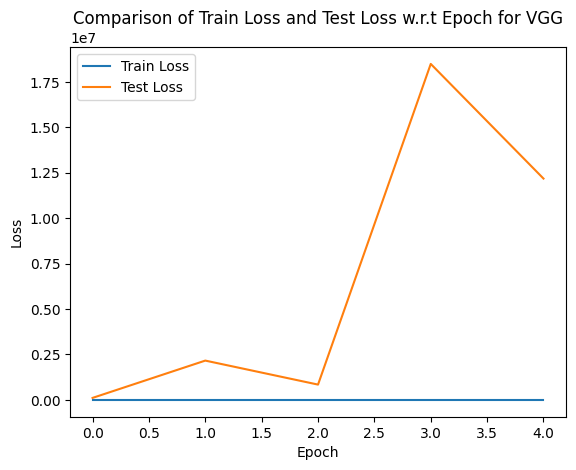

In [ ]:
plt.plot(train_loss3, label="Train Loss")
plt.plot(test_loss3, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Comparison of Train Loss and Test Loss w.r.t Epoch for VGG")
plt.legend()
plt.show()

### Confusion Matrix

In [ ]:
y_pred = vgg_model.predict(test_generator)
y_pred_classes = np.round(y_pred)

true_classes = test_generator.classes

cm3 = confusion_matrix(true_classes, y_pred_classes)

print("Confusion Matrix:")
print(cm3)


87/87 ━━━━━━━━━━━━━━━━━━━━ 11s 123ms/step
Confusion Matrix:
[[1315 1440]
 [1387 1368]]


### Heat Map of Confusion Matrix

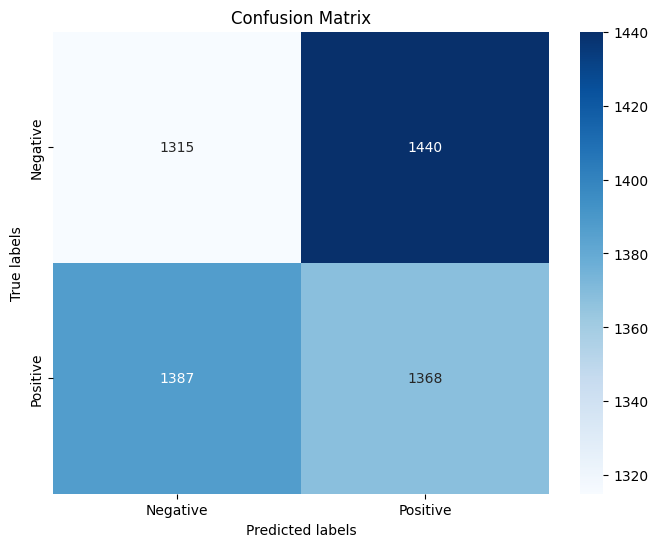

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm3, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()